# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA)
by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets.
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm
!unzip ATnT.zip

Archive:  ATnT.zip
  inflating: ATnT/README             
   creating: ATnT/s1/
  inflating: ATnT/s1/1.pgm           
  inflating: ATnT/s1/10.pgm          
  inflating: ATnT/s1/2.pgm           
  inflating: ATnT/s1/3.pgm           
  inflating: ATnT/s1/4.pgm           
  inflating: ATnT/s1/5.pgm           
  inflating: ATnT/s1/6.pgm           
  inflating: ATnT/s1/7.pgm           
  inflating: ATnT/s1/8.pgm           
  inflating: ATnT/s1/9.pgm           
   creating: ATnT/s10/
  inflating: ATnT/s10/1.pgm          
  inflating: ATnT/s10/10.pgm         
  inflating: ATnT/s10/2.pgm          
  inflating: ATnT/s10/3.pgm          
  inflating: ATnT/s10/4.pgm          
  inflating: ATnT/s10/5.pgm          
  inflating: ATnT/s10/6.pgm          
  inflating: ATnT/s10/7.pgm          
  inflating: ATnT/s10/8.pgm          
  inflating: ATnT/s10/9.pgm          
   creating: ATnT/s11/
  inflating: ATnT/s11/1.pgm          
  inflating: ATnT/s11/10.pgm         
  inflating: ATnT/s11/2.pgm          
 

#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [ ]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """

    # Center the data
    mean = np.mean(X, axis=0)
    X_centered = X - mean

    # Compute covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select top numComponents eigenvectors
    principal_components = eigenvectors[:, :numComponents]

    return principal_components


# Example usage
n_components = 15
trainFaces_flatten = trainFaces.reshape((trainFaces.shape[0], -1))
eigenfaces = principalComponentAnalysis(trainFaces_flatten, n_components)


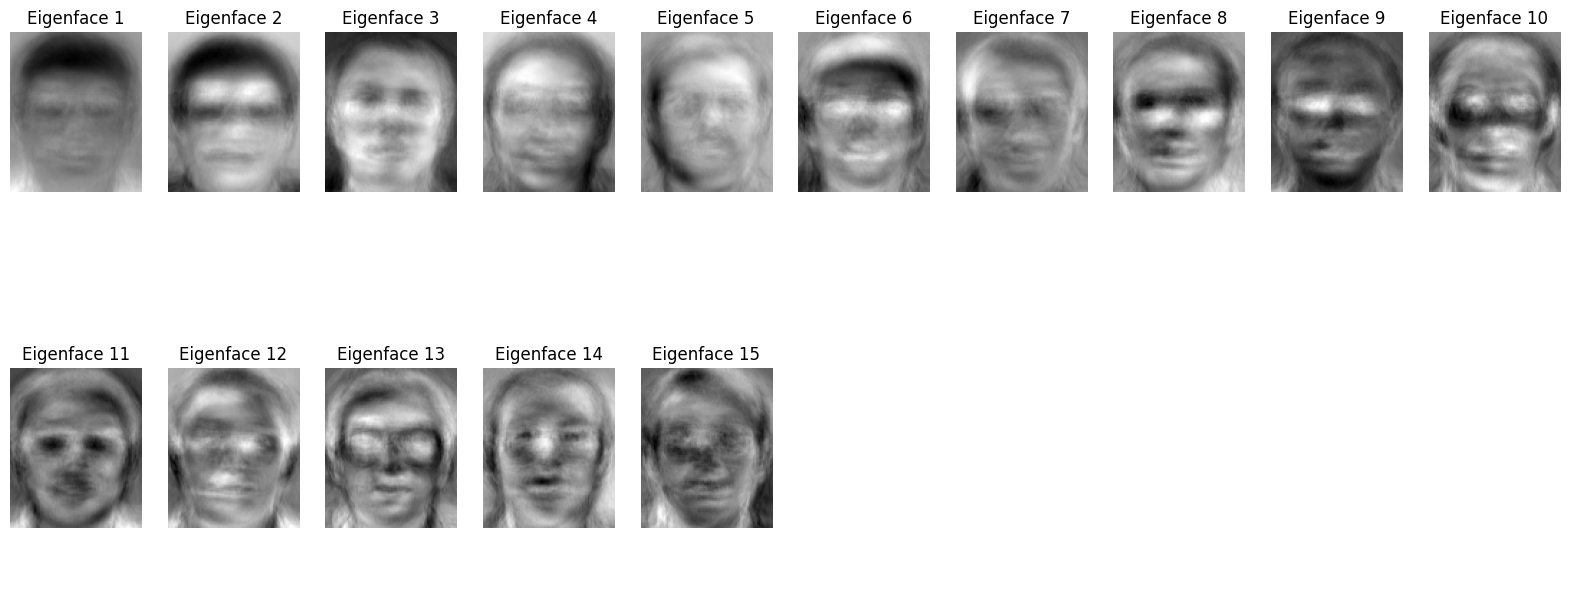

In [ ]:

def plot_eigenfaces(eigenfaces, n_eigenfaces=10):
    num_rows = (n_eigenfaces + 9) // 10
    fig, axes = plt.subplots(num_rows, 10, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        if i < n_eigenfaces:
            ax.imshow(eigenfaces[:, i].reshape(112, 92), cmap='gray')
            ax.set_title(f'Eigenface {i+1}')
            ax.axis('off')
        else:
            ax.axis('off')
    plt.show()

plot_eigenfaces(eigenfaces, n_components)



In [ ]:
testFaces_flatten = testFaces.flatten()
trainFaces_flatten = trainFaces.reshape((trainFaces.shape[0], -1))

#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [ ]:
def imageReconstruction(testFaces_flatten, eigenFaces, meanFace):
    """
    Helper function to reconstruct images
    """
    weights = np.dot(testFaces_flatten - meanFace.flatten(), eigenFaces)
    reconstructed_image = meanFace.flatten() + np.dot(weights, eigenFaces.T)
    return reconstructed_image.reshape(meanFace.shape)

Example usage
test_image_index = 0  # You can change this index as needed
reconstructed_image = imageReconstruction(testFaces_flatten[test_image_index], eigenfaces, trainFaces.mean(axis=0))

# Display the original and reconstructed images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(testFaces[test_image_index], cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed')

plt.tight_layout()
plt.show()


In [ ]:
# plot recontructions here
%matplotlib inline
def plot_reconstructions(testFaces_flatten, eigenFaces, meanFace, num_components_list):
    plt.figure(figsize=(15, 6))

    for i, num_components in enumerate(num_components_list, 1):
        reconstructed_images = [imageReconstruction(img, eigenFaces[:, :num_components], meanFace) for img in testFaces_flatten]

        plt.subplot(2, len(num_components_list), i)
        plt.imshow(testFaces_flatten[0], cmap='gray')  # Display the first test image
        plt.title(f'Original')
        plt.axis('off')

        plt.subplot(2, len(num_components_list), i + len(num_components_list))
        plt.imshow(reconstructed_images[0], cmap='gray')  # Display the reconstructed image
        plt.title(f'Reconstructed (Components={num_components})')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
num_components_list = [10]
plot_reconstructions(testFaces_flatten, eigenfaces, trainFaces.mean(axis=0), num_components_list)


#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

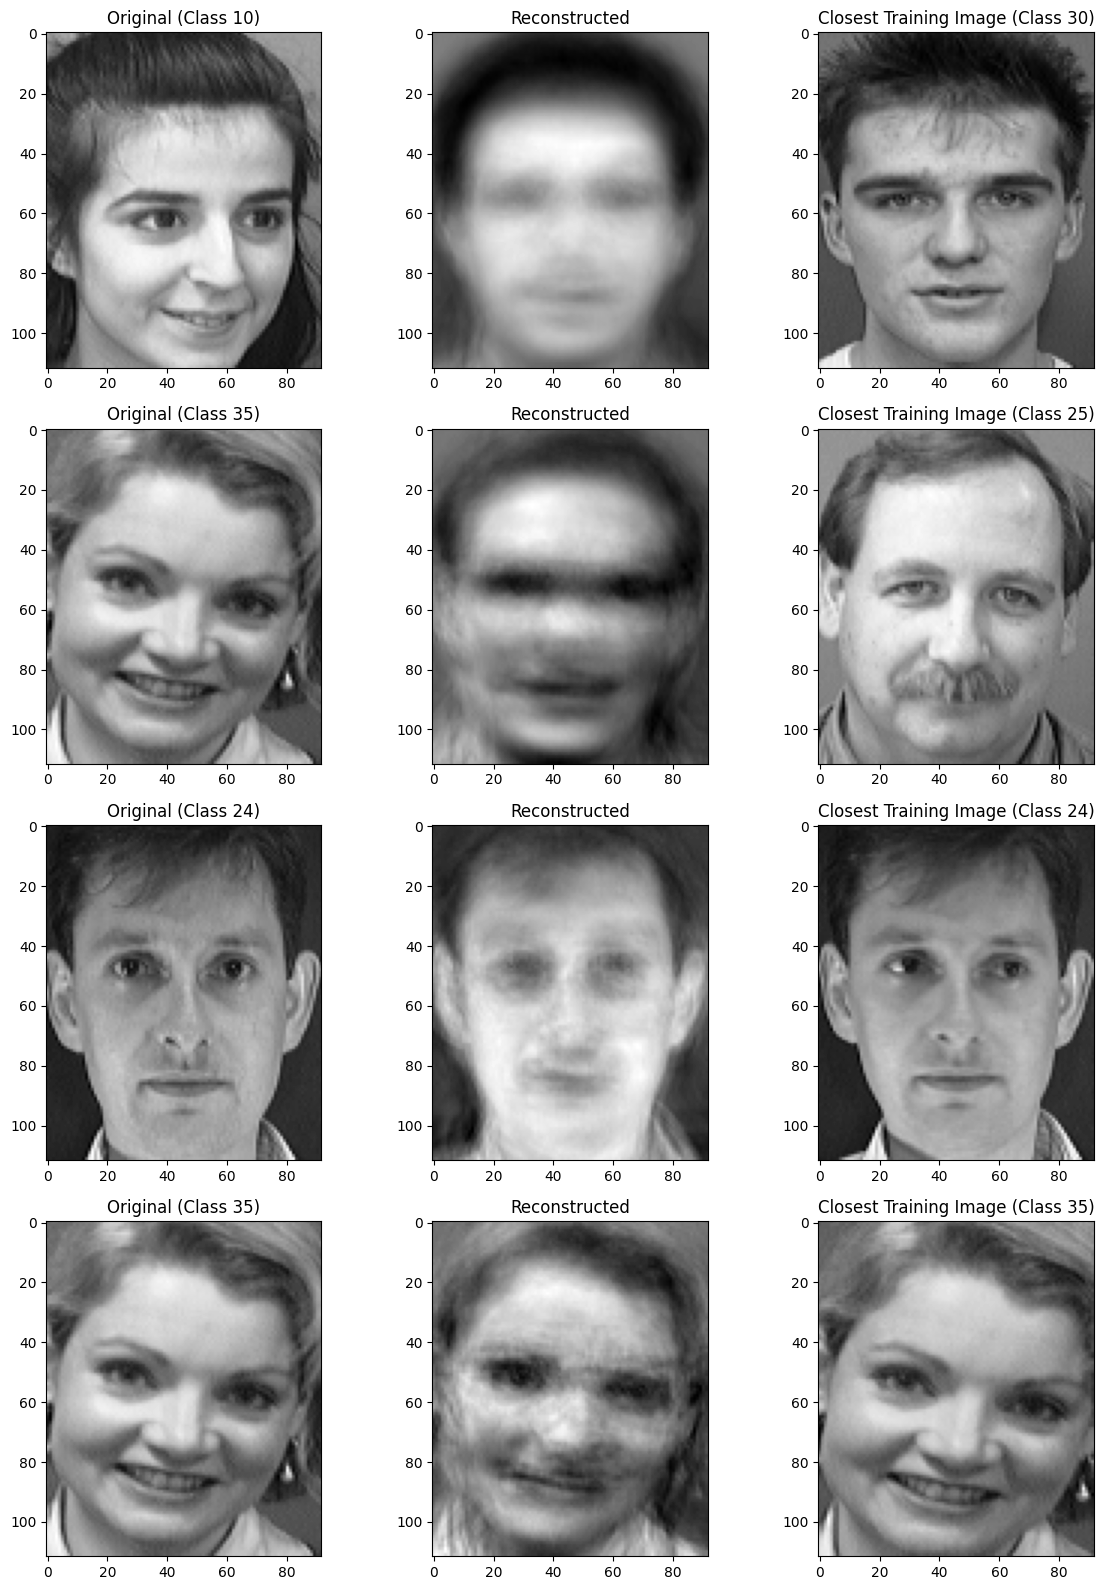

In [ ]:
%matplotlib inline

def displayNfactors(trainFaces, trainLabels, testFaces, eigenfaces, num_components_list):
    fig, axes = plt.subplots(nrows=len(num_components_list), ncols=3, figsize=(12, 4 * len(num_components_list)))

    for i, numComponents in enumerate(num_components_list):
        # Use the first 'numComponents' eigenfaces for reconstruction
        eigenfaces_subset = eigenfaces[:, :numComponents]

        # Randomly select a test image for visualization
        test_image_index = np.random.randint(len(testFaces))
        test_image = testFaces[test_image_index]
        true_label = testLabels[test_image_index]

        # Use the getClass function to get the reconstructed image and prediction
        reconstructed_image = imageReconstruction(test_image.flatten(), eigenfaces_subset, trainFaces.mean(axis=0))

        # Plot original, reconstructed, and closest images
        axes[i, 0].imshow(test_image, cmap='gray')
        axes[i, 0].set_title(f'Original (Class {true_label})')

        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed')

        # Find the closest image in the training set based on L2 distance in the reduced space
        train_faces_flatten = trainFaces.reshape((trainFaces.shape[0], -1))
        test_image_flatten = test_image.flatten()
        weights = np.dot(test_image_flatten - train_faces_flatten.mean(axis=0), eigenfaces_subset)
        closest_image_index = np.argmin(np.linalg.norm(train_faces_flatten - (train_faces_flatten.mean(axis=0) + np.dot(weights, eigenfaces_subset.T)).reshape(-1), axis=1))
        closest_label = trainLabels[closest_image_index]

        axes[i, 2].imshow(trainFaces[closest_image_index], cmap='gray')
        axes[i, 2].set_title(f'Closest Training Image (Class {closest_label})')

    plt.tight_layout()
    plt.show()

# Example usage
num_components_list = [5, 10, 50, 100]  # You can add more values as needed
displayNfactors(trainFaces, trainLabels, testFaces, principalComponentAnalysis(trainFaces_flatten, max(num_components_list)), num_components_list)


#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them.
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations.
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [ ]:
def getClass(test_image, eigenfaces, mean_face, training_set):
    """
    Arguments:
    1. test_image
    2. eigenfaces
    3. mean_face
    4. training_set

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
    """

    # Flatten the test image
    test_image_flatten = test_image.flatten()

    # Center the test image
    centered_test_image = test_image_flatten - mean_face.flatten()

    # Project the test image onto the eigenfaces
    weights = np.dot(centered_test_image, eigenfaces)

    # Reconstruct the test image using the weights, eigenfaces, and mean_face
    reconstructed_image = mean_face.flatten() + np.dot(weights, eigenfaces.T)

    # Reshape the reconstructed image to its original shape
    reconstructed_image = reconstructed_image.reshape(test_image.shape)

    # Calculate the error (residual) between the original and reconstructed image
    error = np.sum(np.square(test_image - reconstructed_image))

    # Find the index of the training image with the smallest error
    min_error_index = np.argmin([np.sum(np.square(training_image - reconstructed_image)) for training_image in training_set])

    # Get the corresponding training image and label
    closest_image = training_set[min_error_index]
    prediction_class = trainLabels[min_error_index]

    return closest_image, error, prediction_class

# Example usage
components = [3, 5, 10, 20, 30, 40, 50]
mse = []

for numComponents in components:
    # Obtain eigenfaces based on the current number of components
    eigenfaces = principalComponentAnalysis(trainFaces_flatten, numComponents)

    mse_list = []

    for i in range(len(testFaces)):
        _, mse_value, _ = getClass(testFaces[i], eigenfaces, trainFaces.mean(axis=0), trainFaces)
        mse_list.append(mse_value)

    mse.append(np.mean(mse_list))



Iterate through all the images in the test data and test the accuracy by taking different number of components

Plot Number of eigenvectors vs Mean Square Error

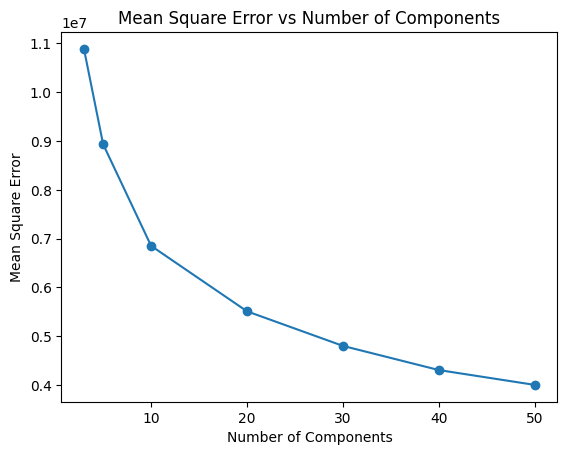

In [ ]:
# your code here
# Plot mean square error vs number of components
plt.plot(components, mse, marker='o')
plt.title('Mean Square Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Mean Square Error')
plt.show()


Plot Number of eigenvectors vs Logarithmic Mean Square Error

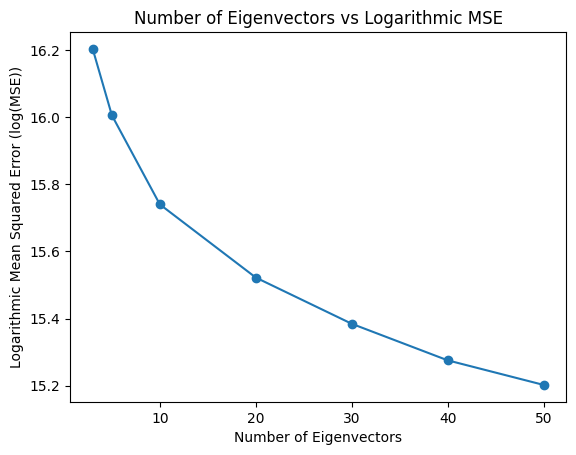

In [ ]:
# your code here
plt.plot(components, np.log(mse), marker='o')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Logarithmic Mean Squared Error (log(MSE))')
plt.title('Number of Eigenvectors vs Logarithmic MSE')
plt.show()